# Single Agent System with Langraph with WatsonX

Hello everyone today we are going to learn how o build a Single Agent System with Langraph with WatsonX
We'll start with a basic chatbot introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic

# Used for install IBM WatsonX
%pip install python-dotenv  ibm_watson_machine_learning
%pip install "ibm-watsonx-ai" 
%pip install "pydantic>=1.10.0" 
%pip install "langchain>=0.1.52"
%pip install "langchain_ibm>=0.1.7"


Then we setup our API keys:

In [1]:
import os
from dotenv import load_dotenv
import getpass
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"


(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## Part 1: Basic Chatbot with WatsonX and LangGraph
Let's create a simple chatbot using LangGraph with WatsonX. This chatbot will respond directly to user messages.

**What is LangGraph?**
LangGraph is a powerful tool that helps us build complex systems, like chatbots, by connecting different pieces of code together. Think of it like a flowchart, where each step builds on the previous one.

**Creating a StateGraph**
We'll start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". This means we can think of our chatbot as a series of states, and we'll define how it transitions between these states.

**Adding Nodes and Edges**
We'll add `nodes` to represent the different functions our chatbot can perform, like responding to user messages. We'll also add `edges` to specify how the bot should transition between these functions.

Here's the code that sets up the LangGraph State:

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


**Understanding the Code**
Let's break down what's happening in this code:

* We've defined our `State` as a special type of dictionary called a `TypedDict`. This dictionary has a single key: `messages`.
* The `messages` key is special because we're telling LangGraph how to update it. We're using a function called `add_messages` to say, "Hey, when we add new messages, append them to the existing list instead of overwriting it."
* Now our graph knows two important things:
	1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
	2. `messages` will be appended to the current list, rather than directly overwritten.

**Next Steps**
Next, we'll add a "chatbot" node. Nodes represent individual tasks or functions, and they're typically regular Python functions. We'll explore this in more detail in the next section.

**Foundation Models on WatsonX.ai**

WatsonX.ai provides a range of foundation models that can be used for various natural language processing tasks. These models are trained on large datasets and can be fine-tuned for specific tasks.

**List of Available Models**

The available models on WatsonX.ai are listed under the `ModelTypes` class. Here's how you can print the list of available models:

In [4]:
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

print([model.name for model in ModelTypes])

['FLAN_T5_XXL', 'FLAN_UL2', 'MT0_XXL', 'GPT_NEOX', 'MPT_7B_INSTRUCT2', 'STARCODER', 'LLAMA_2_70B_CHAT', 'LLAMA_2_13B_CHAT', 'GRANITE_13B_INSTRUCT', 'GRANITE_13B_CHAT', 'FLAN_T5_XL', 'GRANITE_13B_CHAT_V2', 'GRANITE_13B_INSTRUCT_V2', 'ELYZA_JAPANESE_LLAMA_2_7B_INSTRUCT', 'MIXTRAL_8X7B_INSTRUCT_V01_Q', 'CODELLAMA_34B_INSTRUCT_HF', 'GRANITE_20B_MULTILINGUAL']


This will output a list of available models, including `FLAN_T5_XXL`, `FLAN_UL2`, `MT0_XXL`, and more.

**Choosing a Model**

For this example, let's choose the `ibm/granite-13b-instruct-v2` model.

**Defining the Model Parameters**

We need to define the model parameters for the `ibm/granite-13b-instruct-v2` model. We can do this using the `GenTextParamsMetaNames` class.

In [5]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}



**Initializing the WatsonXLLM Class**

Next, we need to initialize the `WatsonxLLM` class, which is a wrapper around the WatsonX.ai models that provides LangChain integration.

In [6]:
from langchain_ibm import WatsonxLLM
model_id = "ibm/granite-13b-instruct-v2"
llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

In [7]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup

In [9]:
from langchain_core.tools import tool
# Tool definition
@tool
def websearch(query, num_results=10):
    """
    Perform a web search for the given query, retrieve descriptions and first paragraphs
    from the results, and print them in a readable format. Also, append all descriptions
    into a single string and print it.

    Args:
        query (str): The search query.
        num_results (int): The number of search results to retrieve. Default is 10.

    Returns:
        None
    """    
    all_descriptions = ""
    results_data = []
    results = search(query, num_results=num_results)

    for url in results:
        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            meta_description = soup.find('meta', attrs={'name': 'description'})
            description_content = meta_description['content'].strip() if meta_description else 'No description available.'
            first_paragraph = soup.find('p')
            first_sentence = first_paragraph.text.strip()[:500] if first_paragraph else 'No paragraph available.'
            all_descriptions += description_content + "\n"
            results_data.append({
                'url': url,
                'description': description_content,
            })
        except requests.RequestException as e:
            print(f"Failed to retrieve {url}: {e}")
        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")

    return all_descriptions

In [10]:
websearch.invoke("Who is Ruslan Magana")

Failed to retrieve https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna: 403 Client Error: Forbidden for url: https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


'I am an expert in Artificial Intelligence with a focus on Neural Networks. My primary… · Esperienza: IBM · Formazione: Università degli Studi di Genova · Località: Milano · 266 collegamenti su LinkedIn. Vedi il profilo di Ruslan Magana Vsevolodovna, PhD su LinkedIn, una community professionale di 1 miliardo di utenti.\nWe talk about Machine Learning, Generative AI, Data Science and Cloud Development\nAbout Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist.\nI am Data Scientist and Data Engineer. I have a Ph.D. in Physics  and I am AWS certified in Machine Learning and Data Analytics - ruslanmv\nI’m happy to share that I’ve obtained a new certification: watsonx.data Technical Sales Intermediate from IBM!\nRead writing from Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist. Every day, Ruslan Magana Vsevolodovna and thousands of other voices read, write, and share important stories on Medium.\nNo descri

In [11]:
print(llm.invoke("Who is Ruslan Magana"))

ev?Ruslan Maganaev (born 5 November 1982) is a Russian professional ice hockey winger currently playing for Yaroslavl Vityaz. He previously played for Vityaz Podolsk. In the Russian Superleague he played for Traktor Chelyabinsk, Salavat Yulaev Ufa and Metallurg Magnitogorsk.


In [12]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 200,
    GenParams.MIN_NEW_TOKENS:  10,
    GenParams.TEMPERATURE: 0.5,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
from langchain_ibm import WatsonxLLM
model_id = "ibm/granite-13b-instruct-v2"
llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

In [13]:
from langchain.tools.render import render_text_description
rendered_tools = render_text_description([websearch])
rendered_tools

'websearch(query, num_results=10) - Perform a web search for the given query, retrieve descriptions and first paragraphs\nfrom the results, and print them in a readable format. Also, append all descriptions\ninto a single string and print it.\n\nArgs:\n    query (str): The search query.\n    num_results (int): The number of search results to retrieve. Default is 10.\n\nReturns:\n    None'

In [19]:
from langchain_core.prompts import ChatPromptTemplate
system_prompt = f"""You are an assistant that has access to the following set of tools. 
Here are the names and descriptions for each tool:
{rendered_tools}.
Given the user input, return the name and input of the tool to use. 
Always return your response as a JSON blob with 'name' and 'arguments' keys.
"""
prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt), ("user", "{input}")]
)
from langchain_core.output_parsers import JsonOutputParser
from operator import itemgetter
llm_chain = prompt | llm
result = llm_chain.invoke({"Who is Ruslan Magana"})
print(result)

name: Human, arguments: Who is Ruslan Magana


In [344]:
system_prompt = f"""
As the assistant, you have access to a variety of tools. Here's a list of available tools: {rendered_tools}. 
When a user poses a question, your objective is to select the most suitable tool and provide the necessary input. 
Your response should be in the form of a JSON object containing the tool's name and its corresponding arguments.
For example, if the user asks: "Who is Ruslan Magana", you should respond with a JSON object like this:
{{
    "name": "websearch",
    "arguments": {{
        "query": "Who is Ruslan Magana",
        "num_results": 10
    }}
}}
"""
print(system_prompt)


As the assistant, you have access to a variety of tools. Here's a list of available tools: websearch(query, num_results=10) - Perform a web search for the given query, retrieve descriptions and first paragraphs
from the results, and print them in a readable format. Also, append all descriptions
into a single string and print it.

Args:
    query (str): The search query.
    num_results (int): The number of search results to retrieve. Default is 10.

Returns:
    None. 
When a user poses a question, your objective is to select the most suitable tool and provide the necessary input. 
Your response should be in the form of a JSON object containing the tool's name and its corresponding arguments.
For example, if the user asks: "Who is Ruslan Magana", you should respond with a JSON object like this:
{
    "name": "websearch",
    "arguments": {
        "query": "Who is Ruslan Magana",
        "num_results": 10
    }
}



In [20]:
system_prompt = f"""
As the assistant, you have access to a variety of tools. Here's a list of available tools: {rendered_tools}. 
When a user poses a question, your objective is to select the most suitable tool and provide the necessary input. 
Your response should be in the form of a JSON blob containing the tool's name and its corresponding arguments.
For example, if the user asks: "Who is Ruslan Magana", you should respond with JSON blob format.
"""
print(system_prompt)


As the assistant, you have access to a variety of tools. Here's a list of available tools: websearch(query, num_results=10) - Perform a web search for the given query, retrieve descriptions and first paragraphs
from the results, and print them in a readable format. Also, append all descriptions
into a single string and print it.

Args:
    query (str): The search query.
    num_results (int): The number of search results to retrieve. Default is 10.

Returns:
    None. 
When a user poses a question, your objective is to select the most suitable tool and provide the necessary input. 
Your response should be in the form of a JSON blob containing the tool's name and its corresponding arguments.
For example, if the user asks: "Who is Ruslan Magana", you should respond with JSON blob format.



In [21]:
# Create the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{input}")
])
# Chain the prompt template with the LLM
llm_chain = prompt | llm
# Invoke the chain with the input
result = llm_chain.invoke({ "Who is Ruslan Magana"})
print(result)



websearch(query, num_results=10)


In [22]:
import json
@tool
def json_format(input_string):
    """input_string : string of the form 'websearch("Who is Ruslan Magana", num_results=10)'
    """
    # Split the input string into function name and arguments
    function_name, arguments_str = input_string.split('(', 1)
    arguments_str = arguments_str.rstrip(')')

    # Split the arguments string into individual arguments
    arguments = {}
    for arg in arguments_str.split(','):
        arg = arg.strip()
        if '=' in arg:
            key, value = arg.split('=')
            key = key.strip('"')  # Remove quotes around the key
            value = value.strip('"')  # Remove quotes around the value
            arguments[key] = value
        else:
            # If argument doesn't have key=value format, consider it as positional
            arguments['query'] = arg.strip('"')

    # Create the JSON object
    json_data = {
        "name": function_name,
        "arguments": arguments
    }

    return json_data

# Example usage:
input_string = 'websearch("Who is Ruslan Magana", num_results=10)'
json_data = json_format.invoke(input_string)

# Convert the JSON object to a string
#json_string = json.dumps(json_data, indent=4)

# Print or save the JSON string
print(json_data)


{'name': 'websearch', 'arguments': {'query': 'Who is Ruslan Magana', 'num_results': '10'}}


In [23]:
json_data['name'] ,json_data['arguments']

('websearch', {'query': 'Who is Ruslan Magana', 'num_results': '10'})

In [38]:
from langchain_core.output_parsers import JsonOutputParser
from operator import itemgetter
# Create the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{input}")
])
# Chain the prompt template with the LLM
llm_chain = prompt | llm | json_format | itemgetter("arguments") | itemgetter("query") |websearch
# Invoke the chain with the input
result = llm_chain.invoke({ "Who is Ruslan Magana"})
print(result)

Failed to retrieve https://it.linkedin.com/in/ruslanmv: 429 Client Error: Request denied for url: https://it.linkedin.com/in/ruslanmv
Failed to retrieve https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna: 403 Client Error: Forbidden for url: https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna
We talk about Machine Learning, Generative AI, Data Science and Cloud Development
About Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist.
I am Data Scientist and Data Engineer. I have a Ph.D. in Physics  and I am AWS certified in Machine Learning and Data Analytics - ruslanmv
I’m happy to share that I’ve obtained a new certification: watsonx.data Technical Sales Intermediate from IBM!
Read writing from Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist. Every day, Ruslan Magana Vsevolodovna and thousands of other voices read, write, and share important stories on Medium.
Play Ruslan Magan

In [48]:
from langchain.prompts import PromptTemplate
template2 = "You are a chatbot you should answer this question {question} and summarize the following websearch results: {result_websearch}. Answer:"
prompt2 = PromptTemplate.from_template(template2)

In [50]:
# WatsonxLLM parameters and model initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 500,
    GenParams.MIN_NEW_TOKENS: 50, # Ensure a minimum length for responses
    GenParams.TEMPERATURE: 0.7, # Lower temperature for more focused output
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

In [51]:
# Chain the prompt template with the LLM
llm_chain = prompt | llm | json_format | itemgetter("arguments") | itemgetter("query") |websearch | (lambda result: prompt2.format(question=question, result_websearch=result)) | watsonx_llm
# Invoke the chain with the input
# Example usage with LangChain chain
question = "Who is Ruslan Magana"
result = llm_chain.invoke({question})
print(result)

Failed to retrieve https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna: 403 Client Error: Forbidden for url: https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna
No description available.
Ruslan Magana is a Data Scientist and Data Engineer. He has a Ph.D. in Physics and is AWS certified in Machine Learning and Data Analytics. Ruslan Magana has a profile on Medium where he writes about Machine Learning, Generative AI, Data Science and Cloud Development. Ruslan Magana also has a profile on SoundCloud where he uploads his own music. Ruslan Magana is also a Nuclear Physics expert.



**Creating the Chatbot Node**

Now that we have the `WatsonxLLM` object, we can create a chatbot node that uses this model to respond to user input.

In [39]:
def chatbot(state: State):
    return {"messages": [llm_chain.invoke(state["messages"])]}

In [40]:
graph_builder.add_node("chatbot", chatbot)


This code defines a `chatbot` function that takes the current `State` as input and returns an updated `messages` list. 

The `chatbot` function uses the `llm` object to generate a response to the user's input, and returns a new `messages` list with the response appended to it.

 Finally, we add the `chatbot` node to our graph using the `add_node` method.

In [41]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [42]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [43]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

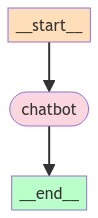

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Testig our Chatbot

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1])